In [70]:
# 기본적인 부분
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("font", family="Nanum Gothic")
plt.rcParams["axes.unicode_minus"]=False

# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 학습 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.special import expit, softmax

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier

# 서울시 상권 월간 매출 예측 모델

## 상권 추정매출

In [71]:
seoul_sales = pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
seoul_sales.shape

(87179, 55)

In [72]:
seoul_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


In [73]:
seoul_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        87179 non-null  int64  
 1   상권_구분_코드         87179 non-null  object 
 2   상권_구분_코드_명       87179 non-null  object 
 3   상권_코드            87179 non-null  int64  
 4   상권_코드_명          87179 non-null  object 
 5   서비스_업종_코드        87179 non-null  object 
 6   서비스_업종_코드_명      87179 non-null  object 
 7   당월_매출_금액         87179 non-null  float64
 8   당월_매출_건수         87179 non-null  int64  
 9   주중_매출_금액         87179 non-null  float64
 10  주말_매출_금액         87179 non-null  float64
 11  월요일_매출_금액        87179 non-null  float64
 12  화요일_매출_금액        87179 non-null  float64
 13  수요일_매출_금액        87179 non-null  float64
 14  목요일_매출_금액        87179 non-null  float64
 15  금요일_매출_금액        87179 non-null  float64
 16  토요일_매출_금액        87179 non-null  float64
 17  일요일_매출_금액   

In [74]:
seoul_sales_copy=seoul_sales.copy()

In [75]:
seoul_sales_copy["출근_매출_금액"] = (seoul_sales_copy["시간대_00~06_매출_금액"] + seoul_sales_copy["시간대_06~11_매출_금액"])
seoul_sales_copy["점심_매출_금액"] = (seoul_sales_copy["시간대_11~14_매출_금액"] + seoul_sales_copy["시간대_14~17_매출_금액"])
seoul_sales_copy["퇴근_매출_금액"] = (seoul_sales_copy["시간대_17~21_매출_금액"] + seoul_sales_copy["시간대_21~24_매출_금액"])

columns_to_drop = [
    "서비스_업종_코드", "서비스_업종_코드_명", "상권_구분_코드", "상권_코드",
    "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액",
    "토요일_매출_금액", "일요일_매출_금액",
    "시간대_00~06_매출_금액", "시간대_06~11_매출_금액",
    "시간대_11~14_매출_금액", "시간대_14~17_매출_금액",
    "시간대_17~21_매출_금액", "시간대_21~24_매출_금액",
    "연령대_10_매출_금액", "연령대_20_매출_금액", "연령대_30_매출_금액", 
    "연령대_40_매출_금액", "연령대_50_매출_금액", "연령대_60_이상_매출_금액", 
    "당월_매출_건수", "주중_매출_건수", "주말_매출_건수",
    "월요일_매출_건수", "화요일_매출_건수", "수요일_매출_건수", "목요일_매출_건수", "금요일_매출_건수",
    "토요일_매출_건수", "일요일_매출_건수",
    "시간대_건수~06_매출_건수", "시간대_건수~11_매출_건수",
    "시간대_건수~14_매출_건수", "시간대_건수~17_매출_건수",
    "시간대_건수~21_매출_건수", "시간대_건수~24_매출_건수",
    "남성_매출_건수", "여성_매출_건수",
    "연령대_10_매출_건수", "연령대_20_매출_건수", "연령대_30_매출_건수",
    "연령대_40_매출_건수", "연령대_50_매출_건수", "연령대_60_이상_매출_건수"
]

seoul_sales_copy = seoul_sales_copy.drop(columns=columns_to_drop)
seoul_sales_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   87179 non-null  int64  
 1   상권_구분_코드_명  87179 non-null  object 
 2   상권_코드_명     87179 non-null  object 
 3   당월_매출_금액    87179 non-null  float64
 4   주중_매출_금액    87179 non-null  float64
 5   주말_매출_금액    87179 non-null  float64
 6   남성_매출_금액    87179 non-null  float64
 7   여성_매출_금액    87179 non-null  float64
 8   출근_매출_금액    87179 non-null  float64
 9   점심_매출_금액    87179 non-null  float64
 10  퇴근_매출_금액    87179 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 7.3+ MB


In [76]:
columns_to_sum = seoul_sales_copy.columns[3:20]  # 매출 컬럼

agg_func = {}
# 기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명
for col in seoul_sales_copy.columns[:3]:
    agg_func[col] = "first"
# 나머지
for col in columns_to_sum:
    agg_func[col] = "sum"

seoul_sales_copy_grouped = seoul_sales_copy.groupby(["상권_코드_명", "기준_년분기_코드"]).agg(agg_func)
seoul_sales_copy_grouped.head()

기준_년분기_코드 상권_구분_코드_명       상권_코드_명      당월_매출_금액  \
상권_코드_명      기준_년분기_코드                                                     
4.19민주묘지역 2번 20241          20241       골목상권  4.19민주묘지역 2번  2.612731e+09   
             20242          20242       골목상권  4.19민주묘지역 2번  3.533239e+09   
             20243          20243       골목상권  4.19민주묘지역 2번  3.197639e+09   
             20244          20244       골목상권  4.19민주묘지역 2번  2.733308e+09   
63빌딩         20241          20241       발달상권          63빌딩  2.583266e+10   

                            주중_매출_금액      주말_매출_금액      남성_매출_금액  \
상권_코드_명      기준_년분기_코드                                             
4.19민주묘지역 2번 20241      1.652561e+09  9.601700e+08  1.474064e+09   
             20242      2.228981e+09  1.304257e+09  1.954385e+09   
             20243      1.952483e+09  1.245156e+09  1.741504e+09   
             20244      1.733142e+09  1.000167e+09  1.440694e+09   
63빌딩         20241      2.465147e+10  1.181194e+09  1.816752e+10   

                            여성_매출_금액      출근_매출_금액      점심_매출_금액      퇴근_매출_금액  
상권_코드_명      기준_년분기_코드                                                          
4.19민주묘지역 2번 20241      1.054124e+09  2.384139e+08  1.093005e+09  1.281312e+09  
             20242      1.448425e+09  2.656644e+08  1.618132e+09  1.649442e+09  
             20243      1.274372e+09  2.470045e+08  1.535506e+09  1.415128e+09  
             20244      1.076676e+09  2.547436e+08  1.310020e+09  1.168544e+09  
63빌딩         20241      5.278512e+09  8.995803e+09  1.511013e+10  1.726733e+09

In [77]:
seoul_sales_copy_grouped = seoul_sales_copy_grouped.reset_index(drop=True)

In [78]:
seoul_sales_copy_grouped_sort = seoul_sales_copy_grouped.sort_values(by="기준_년분기_코드", ascending=True)

In [79]:
seoul_sales_copy_grouped_sort.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액
0,20241,골목상권,4.19민주묘지역 2번,2.612731e+09,1.652561e+09,9.601700e+08,1.474064e+09,1.054124e+09,238413872.0,1.093005e+09,1.281312e+09
1493,20241,골목상권,대흥역 3번,9.546294e+09,7.479212e+09,2.067082e+09,4.133725e+09,4.597608e+09,702897263.0,3.974076e+09,4.869321e+09
4042,20241,골목상권,신월중학교,1.099911e+09,7.197126e+08,3.801982e+08,4.108188e+08,6.457459e+08,56251086.0,6.286638e+08,4.149959e+08
4046,20241,골목상권,신자초등학교,4.108634e+09,1.909357e+09,2.199277e+09,1.414769e+09,2.503160e+09,380634756.0,1.606336e+09,2.121663e+09
1489,20241,골목상권,대흥역 2번,8.870460e+09,6.698854e+09,2.171606e+09,4.143065e+09,4.193127e+09,904975893.0,3.987166e+09,3.978318e+09


In [80]:
seoul_sales_copy_grouped_sort = seoul_sales_copy_grouped_sort.reset_index(drop=True)

In [81]:
seoul_sales_copy_grouped_sort.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액
0,20241,골목상권,4.19민주묘지역 2번,2.612731e+09,1.652561e+09,9.601700e+08,1.474064e+09,1.054124e+09,238413872.0,1.093005e+09,1.281312e+09
1,20241,골목상권,대흥역 3번,9.546294e+09,7.479212e+09,2.067082e+09,4.133725e+09,4.597608e+09,702897263.0,3.974076e+09,4.869321e+09
2,20241,골목상권,신월중학교,1.099911e+09,7.197126e+08,3.801982e+08,4.108188e+08,6.457459e+08,56251086.0,6.286638e+08,4.149959e+08
3,20241,골목상권,신자초등학교,4.108634e+09,1.909357e+09,2.199277e+09,1.414769e+09,2.503160e+09,380634756.0,1.606336e+09,2.121663e+09
4,20241,골목상권,대흥역 2번,8.870460e+09,6.698854e+09,2.171606e+09,4.143065e+09,4.193127e+09,904975893.0,3.987166e+09,3.978318e+09


In [82]:
seoul_sales_copy_grouped_sort["상권_코드_명"].unique()

array(['4.19민주묘지역 2번', '대흥역 3번', '신월중학교', ..., '배꽃어린이공원',
       '본마을노인복지센터(서초구립내곡도서관)', '문래역 3번'], dtype=object)

## 유동인구

In [83]:
seoul_people_street=pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")
seoul_people_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         6595 non-null   int64 
 1   상권_구분_코드          6595 non-null   object
 2   상권_구분_코드_명        6595 non-null   object
 3   상권_코드             6595 non-null   int64 
 4   상권_코드_명           6595 non-null   object
 5   총_유동인구_수          6595 non-null   int64 
 6   남성_유동인구_수         6595 non-null   int64 
 7   여성_유동인구_수         6595 non-null   int64 
 8   연령대_10_유동인구_수     6595 non-null   int64 
 9   연령대_20_유동인구_수     6595 non-null   int64 
 10  연령대_30_유동인구_수     6595 non-null   int64 
 11  연령대_40_유동인구_수     6595 non-null   int64 
 12  연령대_50_유동인구_수     6595 non-null   int64 
 13  연령대_60_이상_유동인구_수  6595 non-null   int64 
 14  시간대_00_06_유동인구_수  6595 non-null   int64 
 15  시간대_06_11_유동인구_수  6595 non-null   int64 
 16  시간대_11_14_유동인구_수  6595 non-null   int64 
 17  시간대_14_17_유동인구

In [84]:
seoul_people_street_copy=seoul_people_street.copy()

In [85]:
seoul_people_street_copy["출근_유동인구_수"] = (seoul_people_street_copy["시간대_00_06_유동인구_수"] + seoul_people_street_copy["시간대_06_11_유동인구_수"])
seoul_people_street_copy["점심_유동인구_수"] = (seoul_people_street_copy["시간대_11_14_유동인구_수"] + seoul_people_street_copy["시간대_14_17_유동인구_수"])
seoul_people_street_copy["퇴근_유동인구_수"] = (seoul_people_street_copy["시간대_17_21_유동인구_수"] + seoul_people_street_copy["시간대_21_24_유동인구_수"])

seoul_people_street_copy["주중_유동인구_수"] = (seoul_people_street_copy["월요일_유동인구_수"] +
                                                 seoul_people_street_copy["화요일_유동인구_수"] +
                                                 seoul_people_street_copy["수요일_유동인구_수"] +
                                                 seoul_people_street_copy["목요일_유동인구_수"] +
                                                 seoul_people_street_copy["금요일_유동인구_수"])
seoul_people_street_copy["주말_유동인구_수"] = (seoul_people_street_copy["토요일_유동인구_수"] +
                                                 seoul_people_street_copy["일요일_유동인구_수"])

columns_to_drop = [
    "상권_구분_코드", "상권_코드",
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수", 
    "시간대_00_06_유동인구_수", "시간대_06_11_유동인구_수",
    "시간대_11_14_유동인구_수", "시간대_14_17_유동인구_수",
    "시간대_17_21_유동인구_수", "시간대_21_24_유동인구_수",
    "월요일_유동인구_수", "화요일_유동인구_수", "수요일_유동인구_수", "목요일_유동인구_수", "금요일_유동인구_수",
    "토요일_유동인구_수", "일요일_유동인구_수"
]

seoul_people_street_copy = seoul_people_street_copy.drop(columns=columns_to_drop)
seoul_people_street_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   기준_년분기_코드   6595 non-null   int64 
 1   상권_구분_코드_명  6595 non-null   object
 2   상권_코드_명     6595 non-null   object
 3   총_유동인구_수    6595 non-null   int64 
 4   남성_유동인구_수   6595 non-null   int64 
 5   여성_유동인구_수   6595 non-null   int64 
 6   출근_유동인구_수   6595 non-null   int64 
 7   점심_유동인구_수   6595 non-null   int64 
 8   퇴근_유동인구_수   6595 non-null   int64 
 9   주중_유동인구_수   6595 non-null   int64 
 10  주말_유동인구_수   6595 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 566.9+ KB


In [86]:
seoul_people_street_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,관광특구,이태원 관광특구,2155176,1100997,1054179,825910,616767,712501,1448259,706917
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,1797535,3421049,1671272,5610790,1279068
2,20241,관광특구,동대문패션타운 관광특구,3384560,1595828,1788732,1319830,1041981,1022749,2621333,763228
3,20241,관광특구,종로?청계 관광특구,8440796,4496772,3944023,2502267,3586470,2352059,6677540,1763257
4,20241,관광특구,잠실 관광특구,4110178,1976808,2133370,1481825,1270950,1357403,2909899,1200277


In [87]:
seoul_people_street_copy = seoul_people_street_copy.reset_index(drop=True)

In [88]:
seoul_sales_people_street = pd.merge(seoul_sales_copy_grouped_sort, seoul_people_street_copy, on=["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명"], how="inner")
seoul_sales_people_street.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,골목상권,4.19민주묘지역 2번,2.612731e+09,1.652561e+09,9.601700e+08,1.474064e+09,1.054124e+09,238413872.0,1.093005e+09,1.281312e+09,1021175,429007,592167,503816,222810,294548,719725,301450
1,20241,골목상권,대흥역 3번,9.546294e+09,7.479212e+09,2.067082e+09,4.133725e+09,4.597608e+09,702897263.0,3.974076e+09,4.869321e+09,837971,389403,448567,281579,260104,296289,619072,218900
2,20241,골목상권,신월중학교,1.099911e+09,7.197126e+08,3.801982e+08,4.108188e+08,6.457459e+08,56251086.0,6.286638e+08,4.149959e+08,336591,174884,161707,153514,87195,95883,240975,95614
3,20241,골목상권,신자초등학교,4.108634e+09,1.909357e+09,2.199277e+09,1.414769e+09,2.503160e+09,380634756.0,1.606336e+09,2.121663e+09,1423670,666256,757415,708602,295598,419470,1006691,416978
4,20241,골목상권,대흥역 2번,8.870460e+09,6.698854e+09,2.171606e+09,4.143065e+09,4.193127e+09,904975893.0,3.987166e+09,3.978318e+09,2622423,1208914,1413509,1140486,660453,821482,1898991,723434


In [89]:
seoul_sales_people_street_sorted = seoul_sales_people_street.sort_values(by="기준_년분기_코드", ascending=True)

In [90]:
seoul_people_street_copy = seoul_people_street_copy.reset_index(drop=True)
seoul_people_street_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,관광특구,이태원 관광특구,2155176,1100997,1054179,825910,616767,712501,1448259,706917
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,1797535,3421049,1671272,5610790,1279068
2,20241,관광특구,동대문패션타운 관광특구,3384560,1595828,1788732,1319830,1041981,1022749,2621333,763228
3,20241,관광특구,종로?청계 관광특구,8440796,4496772,3944023,2502267,3586470,2352059,6677540,1763257
4,20241,관광특구,잠실 관광특구,4110178,1976808,2133370,1481825,1270950,1357403,2909899,1200277


In [91]:
seoul_sales_people_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274 entries, 0 to 6273
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   6274 non-null   int64  
 1   상권_구분_코드_명  6274 non-null   object 
 2   상권_코드_명     6274 non-null   object 
 3   당월_매출_금액    6274 non-null   float64
 4   주중_매출_금액    6274 non-null   float64
 5   주말_매출_금액    6274 non-null   float64
 6   남성_매출_금액    6274 non-null   float64
 7   여성_매출_금액    6274 non-null   float64
 8   출근_매출_금액    6274 non-null   float64
 9   점심_매출_금액    6274 non-null   float64
 10  퇴근_매출_금액    6274 non-null   float64
 11  총_유동인구_수    6274 non-null   int64  
 12  남성_유동인구_수   6274 non-null   int64  
 13  여성_유동인구_수   6274 non-null   int64  
 14  출근_유동인구_수   6274 non-null   int64  
 15  점심_유동인구_수   6274 non-null   int64  
 16  퇴근_유동인구_수   6274 non-null   int64  
 17  주중_유동인구_수   6274 non-null   int64  
 18  주말_유동인구_수   6274 non-null   int64  
dtypes: float64(8), int64(9), ob

## 직장인구

In [92]:
seoul_people_working=pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
seoul_people_working.shape

(6549, 26)

In [93]:
seoul_people_working.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553
3,20241,U,관광특구,3001494,종로?청계 관광특구,47296,26388,20908,670,9566,...,7326,7672,5302,1732,428,5452,6816,5204,2256,752
4,20241,U,관광특구,3001495,잠실 관광특구,111557,65817,45740,195,18343,...,18331,18070,13050,7197,115,9254,10943,10338,11338,3752


In [94]:
seoul_people_working_copy=seoul_people_working.copy()

In [95]:
seoul_people_working_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            6549 non-null   int64 
 1   상권_구분_코드             6549 non-null   object
 2   상권_구분_코드_명           6549 non-null   object
 3   상권_코드                6549 non-null   int64 
 4   상권_코드_명              6549 non-null   object
 5   총_직장_인구_수            6549 non-null   int64 
 6   남성_직장_인구_수           6549 non-null   int64 
 7   여성_직장_인구_수           6549 non-null   int64 
 8   연령대_10_직장_인구_수       6549 non-null   int64 
 9   연령대_20_직장_인구_수       6549 non-null   int64 
 10  연령대_30_직장_인구_수       6549 non-null   int64 
 11  연령대_40_직장_인구_수       6549 non-null   int64 
 12  연령대_50_직장_인구_수       6549 non-null   int64 
 13  연령대_60_이상_직장_인구_수    6549 non-null   int64 
 14  남성연령대_10_직장_인구_수     6549 non-null   int64 
 15  남성연령대_20_직장_인구_수     6549 non-null   int64 
 16  남성연령대_

In [96]:
columns_to_drop = [
    "상권_구분_코드", "상권_코드",
    "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
    "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수", 
    "남성연령대_10_직장_인구_수", "남성연령대_20_직장_인구_수", "남성연령대_30_직장_인구_수",
    "남성연령대_40_직장_인구_수", "남성연령대_50_직장_인구_수", "남성연령대_60_이상_직장_인구_수",
    "여성연령대_10_직장_인구_수", "여성연령대_20_직장_인구_수", "여성연령대_30_직장_인구_수",
    "여성연령대_40_직장_인구_수", "여성연령대_50_직장_인구_수", "여성연령대_60_이상_직장_인구_수"
]

seoul_people_working_copy = seoul_people_working_copy.drop(columns=columns_to_drop)
seoul_people_working_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   기준_년분기_코드   6549 non-null   int64 
 1   상권_구분_코드_명  6549 non-null   object
 2   상권_코드_명     6549 non-null   object
 3   총_직장_인구_수   6549 non-null   int64 
 4   남성_직장_인구_수  6549 non-null   int64 
 5   여성_직장_인구_수  6549 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 307.1+ KB


In [97]:
seoul_people_working_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,관광특구,이태원 관광특구,28395,15935,12460
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159
2,20241,관광특구,동대문패션타운 관광특구,33474,16833,16641
3,20241,관광특구,종로?청계 관광특구,47296,26388,20908
4,20241,관광특구,잠실 관광특구,111557,65817,45740


In [98]:
seoul_sales_people_street_working = pd.merge(seoul_sales_people_street, seoul_people_working_copy, on=["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명"], how="inner")
seoul_sales_people_street_working.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,...,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,골목상권,4.19민주묘지역 2번,2.612731e+09,1.652561e+09,9.601700e+08,1.474064e+09,1.054124e+09,238413872.0,1.093005e+09,...,429007,592167,503816,222810,294548,719725,301450,164,107,57
1,20241,골목상권,대흥역 3번,9.546294e+09,7.479212e+09,2.067082e+09,4.133725e+09,4.597608e+09,702897263.0,3.974076e+09,...,389403,448567,281579,260104,296289,619072,218900,1146,674,472
2,20241,골목상권,신월중학교,1.099911e+09,7.197126e+08,3.801982e+08,4.108188e+08,6.457459e+08,56251086.0,6.286638e+08,...,174884,161707,153514,87195,95883,240975,95614,187,107,80
3,20241,골목상권,신자초등학교,4.108634e+09,1.909357e+09,2.199277e+09,1.414769e+09,2.503160e+09,380634756.0,1.606336e+09,...,666256,757415,708602,295598,419470,1006691,416978,686,509,177
4,20241,골목상권,대흥역 2번,8.870460e+09,6.698854e+09,2.171606e+09,4.143065e+09,4.193127e+09,904975893.0,3.987166e+09,...,1208914,1413509,1140486,660453,821482,1898991,723434,1265,800,465


In [99]:
seoul_sales_people_street_working.rename(columns={"당월_매출_금액": "매출_금액"}, inplace=True)

def seasons(row):
    if row == 20241:
        return "봄"
    elif row == 20242:
        return "여름"
    elif row == 20243:
        return "가을"
    else:
        return "겨울"

seoul_sales_people_street_working["계절"] = seoul_sales_people_street_working["기준_년분기_코드"
                                                                            ].apply(seasons)
seoul_sales_people_street_working.insert(seoul_sales_people_street_working.columns.get_loc("기준_년분기_코드") + 1, "계절", seoul_sales_people_street_working.pop("계절"))

In [100]:
seoul_sales_people_street_working = seoul_sales_people_street_working.sort_values(by="기준_년분기_코드", ascending=True)

In [101]:
seoul_sales_people_street_working = seoul_sales_people_street_working.reset_index(drop=True)
seoul_sales_people_street_working.head()

,기준_년분기_코드,계절,상권_구분_코드_명,상권_코드_명,매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,...,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,봄,골목상권,4.19민주묘지역 2번,2.612731e+09,1.652561e+09,9.601700e+08,1.474064e+09,1.054124e+09,2.384139e+08,...,429007,592167,503816,222810,294548,719725,301450,164,107,57
1,20241,봄,발달상권,공릉역,1.497274e+10,1.055107e+10,4.421666e+09,7.932701e+09,5.847239e+09,1.979721e+09,...,306692,337866,250236,176207,218113,446859,197697,2344,1266,1078
2,20241,봄,골목상권,강북구청,3.519543e+09,2.375520e+09,1.144023e+09,2.176455e+09,1.113799e+09,5.118473e+08,...,595162,659448,521083,315867,417661,880002,374609,374,192,182
3,20241,봄,골목상권,종암초등학교,9.388485e+08,7.177452e+08,2.211033e+08,5.597118e+08,3.391022e+08,1.604490e+08,...,76263,76489,78929,31859,41968,109643,43111,221,133,88
4,20241,봄,골목상권,한국폴리텍대학서울정수캠퍼스,1.614450e+09,1.057410e+09,5.570408e+08,8.175390e+08,6.493754e+08,1.976916e+08,...,351829,348489,335774,164993,199552,500855,199462,997,648,349


In [102]:
seoul_sales_people_street_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   6241 non-null   int64  
 1   계절          6241 non-null   object 
 2   상권_구분_코드_명  6241 non-null   object 
 3   상권_코드_명     6241 non-null   object 
 4   매출_금액       6241 non-null   float64
 5   주중_매출_금액    6241 non-null   float64
 6   주말_매출_금액    6241 non-null   float64
 7   남성_매출_금액    6241 non-null   float64
 8   여성_매출_금액    6241 non-null   float64
 9   출근_매출_금액    6241 non-null   float64
 10  점심_매출_금액    6241 non-null   float64
 11  퇴근_매출_금액    6241 non-null   float64
 12  총_유동인구_수    6241 non-null   int64  
 13  남성_유동인구_수   6241 non-null   int64  
 14  여성_유동인구_수   6241 non-null   int64  
 15  출근_유동인구_수   6241 non-null   int64  
 16  점심_유동인구_수   6241 non-null   int64  
 17  퇴근_유동인구_수   6241 non-null   int64  
 18  주중_유동인구_수   6241 non-null   int64  
 19  주말_유동인구_수   6241 non-null  

In [103]:
seoul_sales_people_street_working.to_csv("../data/seoul_sales.csv", index=False)

## 데이터 전처리
> 상관관계 확인  
> 각 변수 시각화  

### 데이터 병합

In [108]:
import os

# 현재 작업 중인 경로 확인
print("현재 경로:", os.getcwd())

# 현재 경로에 있는 파일 목록 보기
print("폴더 안 파일 목록:", os.listdir())

현재 경로: /Users/bboki/Library/CloudStorage/GoogleDrive-bbokizzii@gmail.com/내 드라이브/ESTProject/sales
폴더 안 파일 목록: ['seoul_month_sales_predict.ipynb', '.DS_Store', 'sales_bboki.ipynb', 'avg_sales_by_service.png', '.ipynb_checkpoints', 'avg_sales_by_zone.png', 'seoul_month_sales_predict-checkpoint.ipynb', 'merge_test.ipynb']


In [111]:
# 파일 경로에 맞게 파일 다시 불러오기 (인코딩 주의!)
df_sales = pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding='cp949')
df_population = pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding='cp949')
df_worker = pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding='cp949')

# 병합 기준 컬럼
merge_keys = ['기준_년분기_코드', '상권_코드']

# 병합: 추정매출 → 길단위인구 → 직장인구
merged = pd.merge(df_sales, df_population, on=merge_keys, how='inner')
merged = pd.merge(merged, df_worker, on=merge_keys, how='inner')

# 결과 확인
print("병합된 데이터 shape:", merged.shape)
merged.head()

병합된 데이터 shape: (86981, 104)


,기준_년분기_코드,상권_구분_코드_x,상권_구분_코드_명_x,상권_코드,상권_코드_명_x,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,4986,4313,3583,842,0,4627,4869,2052,722,190
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,4986,4313,3583,842,0,4627,4869,2052,722,190


In [112]:
# 병합 기준 컬럼
merge_keys = ['기준_년분기_코드', '상권_코드']

# 병합: 추정매출 → 길단위인구 → 직장인구
merged = pd.merge(df_sales, df_population, on=merge_keys, how='inner')
merged = pd.merge(merged, df_worker, on=merge_keys, how='inner')

# 결과 확인
print("병합된 데이터 shape:", merged.shape)
merged.head()

병합된 데이터 shape: (86981, 104)


,기준_년분기_코드,상권_구분_코드_x,상권_구분_코드_명_x,상권_코드,상권_코드_명_x,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,4986,4313,3583,842,0,4627,4869,2052,722,190
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,4986,4313,3583,842,0,4627,4869,2052,722,190
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,4986,4313,3583,842,0,4627,4869,2052,722,190


### 결측치 확인

In [113]:
# 결측치 확인
merged.isnull().sum().sort_values(ascending=False)

기준_년분기_코드              0
상권_구분_코드_x             0
목요일_유동인구_수             0
수요일_유동인구_수             0
화요일_유동인구_수             0
                      ..
연령대_60_이상_매출_금액        0
연령대_50_매출_금액           0
연령대_40_매출_금액           0
연령대_30_매출_금액           0
여성연령대_60_이상_직장_인구_수    0
Length: 104, dtype: int64

### 이상치 시각화 (Boxplot)

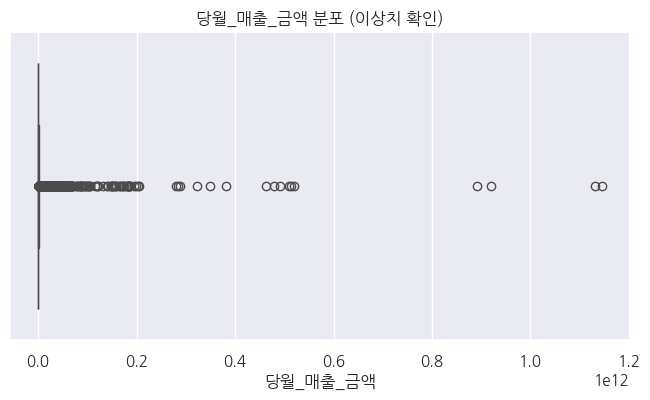

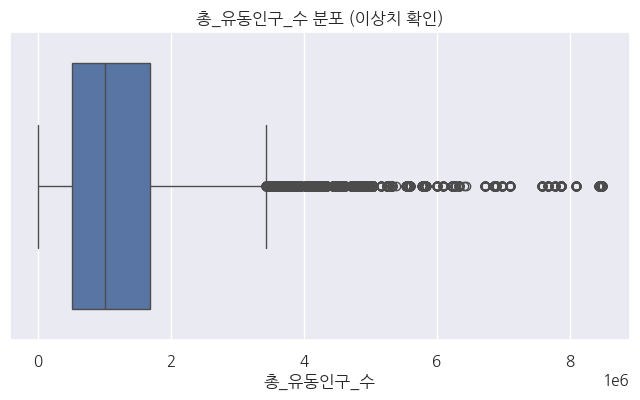

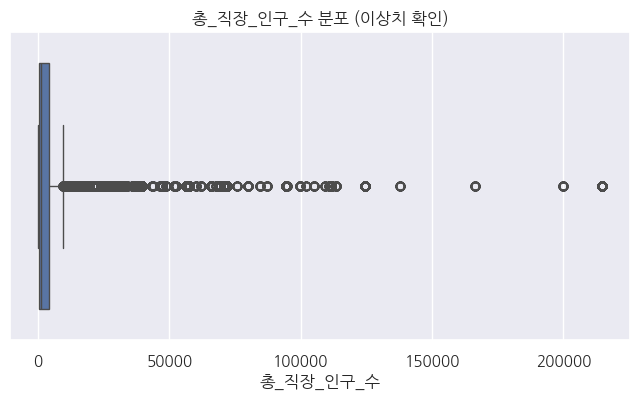

In [114]:
# 확인할 주요 변수
columns_to_check = ['당월_매출_금액', '총_유동인구_수', '총_직장_인구_수']

# 각 변수의 이상치 시각화
for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=merged[col])
    plt.title(f"{col} 분포 (이상치 확인)")
    plt.xlabel(col)
    plt.show()

### 상관관계 히트맵

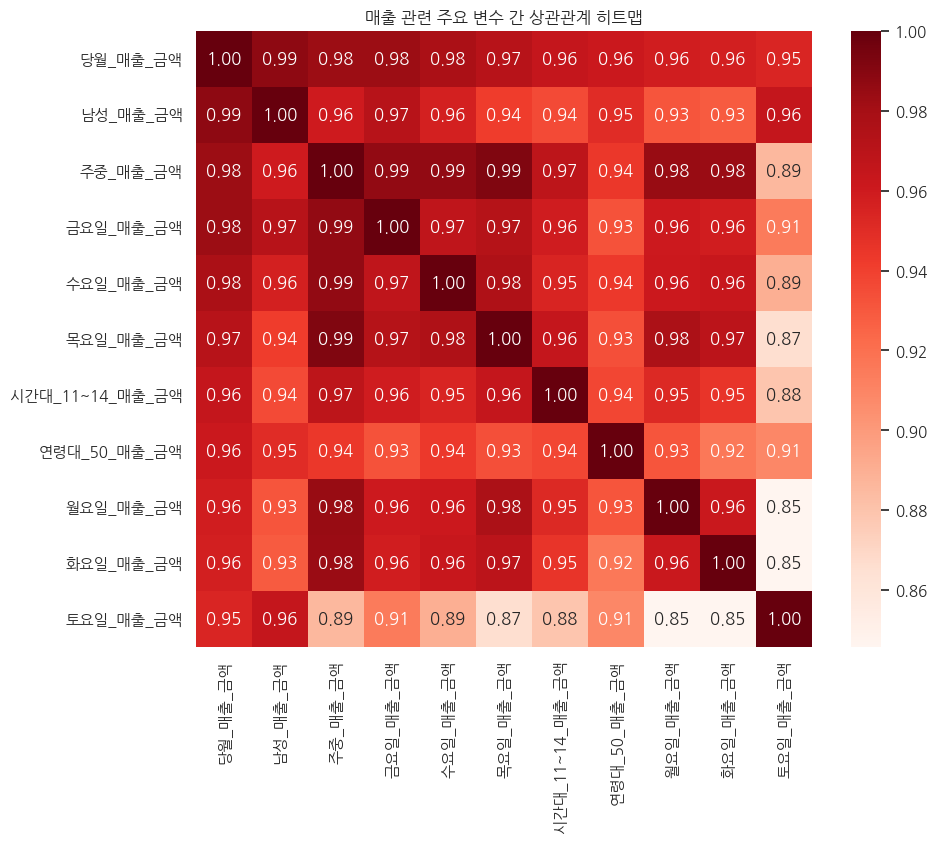

In [115]:
# 수치형 변수만 뽑기
numeric_df = merged.select_dtypes(include=np.number)

# 상관관계 분석
corr_matrix = numeric_df.corr()

# '당월_매출_금액'과 상관계수 높은 변수 TOP 10
target = '당월_매출_금액'
top_corr = corr_matrix[target].abs().sort_values(ascending=False)[1:11]  # 자기 자신 제외

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df[[target] + top_corr.index.tolist()].corr(), annot=True, fmt=".2f", cmap='Reds', square=True)
plt.title('매출 관련 주요 변수 간 상관관계 히트맵')
plt.show()

### 상관관계 높은 변수 정리

In [116]:
# 상관관계 높은 순서로 20개 정도 보기 (자기 자신 제외)
corr_target = numeric_df.corr()['당월_매출_금액'].drop('당월_매출_금액')
corr_sorted = corr_target.abs().sort_values(ascending=False)

# 상위 20개 변수만 보기
corr_sorted.head(20)

남성_매출_금액           0.987683
주중_매출_금액           0.983257
금요일_매출_금액          0.983207
수요일_매출_금액          0.977192
목요일_매출_금액          0.971087
시간대_11~14_매출_금액    0.964736
연령대_50_매출_금액       0.961821
월요일_매출_금액          0.958930
화요일_매출_금액          0.957239
토요일_매출_금액          0.953726
연령대_40_매출_금액       0.950930
시간대_14~17_매출_금액    0.949580
연령대_30_매출_금액       0.945505
주말_매출_금액           0.941844
시간대_17~21_매출_금액    0.941394
여성_매출_금액           0.936162
연령대_60_이상_매출_금액    0.913008
일요일_매출_금액          0.903457
시간대_06~11_매출_금액    0.867520
토요일_매출_건수          0.840376
Name: 당월_매출_금액, dtype: float64

In [118]:
selected_cols = [
    '당월_매출_금액',
    '주중_매출_금액',
    '금요일_매출_금액',
    '연령대_50_매출_금액',
    '연령대_40_매출_금액',
    '시간대_11~14_매출_금액',
    '시간대_17~21_매출_금액',
    '토요일_매출_건수'
]
model_df = merged[selected_cols].copy()
model_df.head()

,당월_매출_금액,주중_매출_금액,금요일_매출_금액,연령대_50_매출_금액,연령대_40_매출_금액,시간대_11~14_매출_금액,시간대_17~21_매출_금액,토요일_매출_건수
0,1.185751e+10,6.640829e+09,1.857856e+09,1.182058e+09,1.505851e+09,1.882305e+09,3.917848e+09,59431
1,1.911647e+09,1.259317e+09,4.290704e+08,2.319459e+08,2.673641e+08,4.818115e+08,8.822789e+08,7989
2,7.273213e+08,4.611840e+08,1.314572e+08,7.182727e+07,1.030455e+08,8.610870e+07,2.340681e+08,2424
3,1.673468e+10,8.256458e+09,2.692736e+09,1.523778e+09,1.873867e+09,1.821635e+09,5.847274e+09,119766
4,1.255782e+09,7.704259e+08,1.955481e+08,1.679254e+08,1.625520e+08,2.856577e+08,3.625709e+08,19818


#### 당월_매출_금액과 각 변수의 산점도 (Scatter Plot)

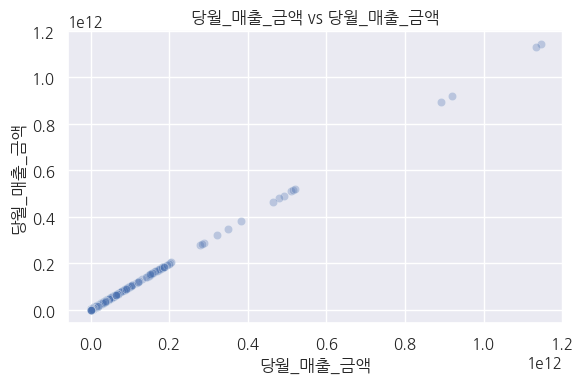

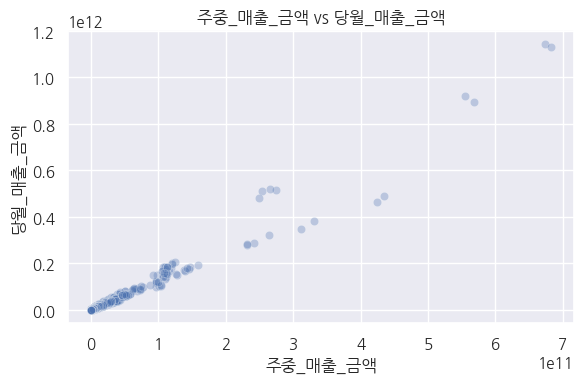

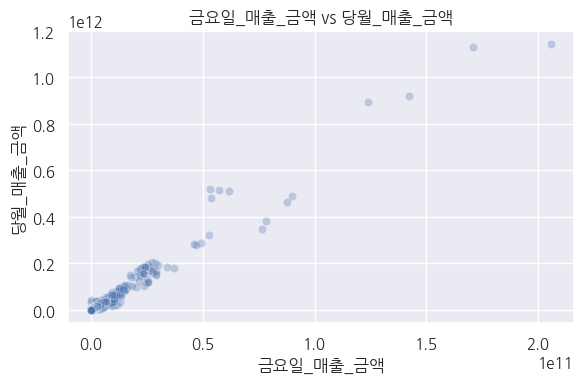

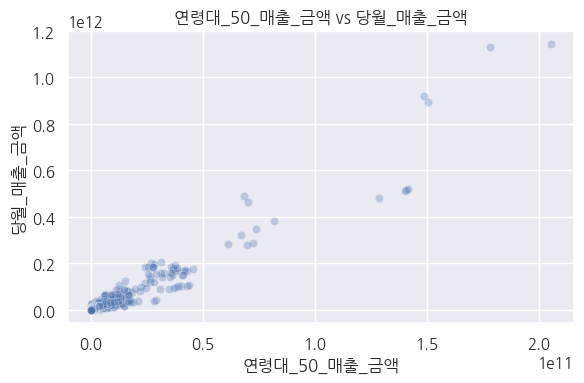

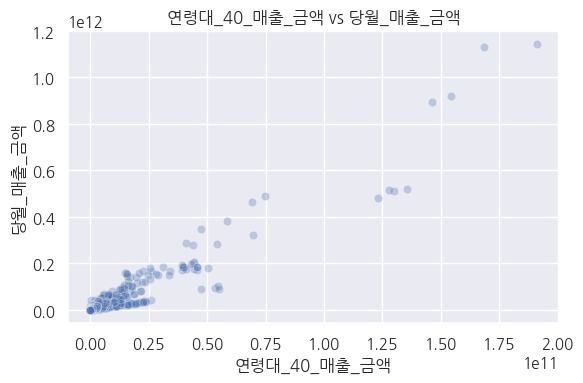

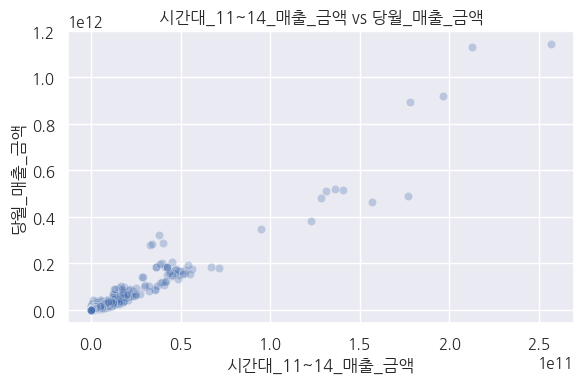

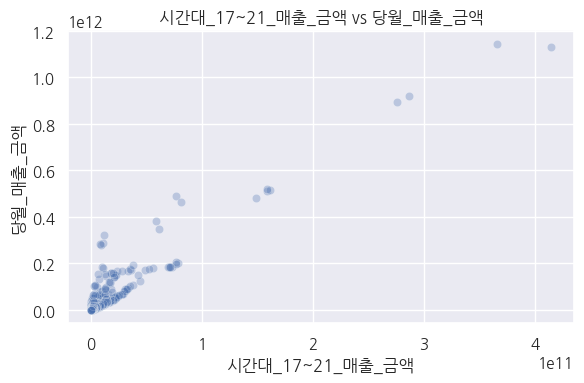

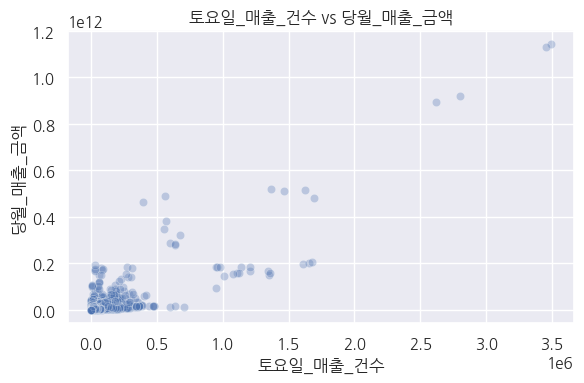

In [119]:
# 산점도 그리기
for col in selected_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=model_df, x=col, y='당월_매출_금액', alpha=0.3)
    plt.title(f'{col} vs 당월_매출_금액')
    plt.xlabel(col)
    plt.ylabel('당월_매출_금액')
    plt.tight_layout()
    plt.show()

 #### 상관계수 막대그래프로 한눈에 보기

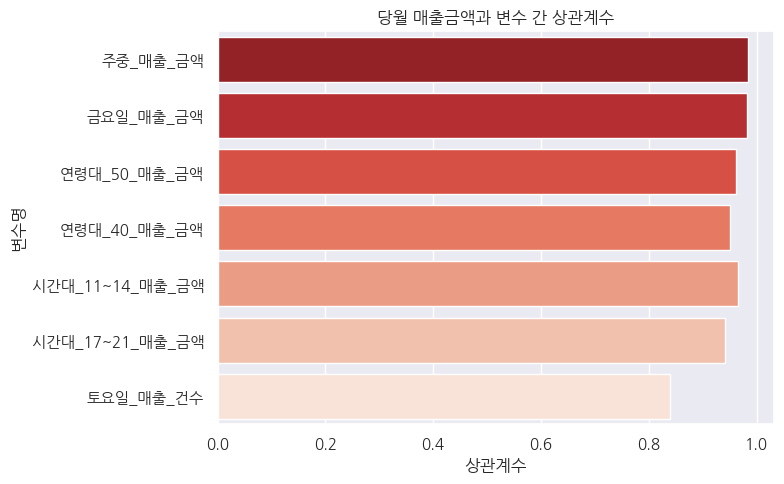

In [121]:
# 상관계수 시각화
selected_corr = model_df.corr()['당월_매출_금액'].drop('당월_매출_금액')

# 데이터프레임으로 변환해서 hue 사용
corr_df = selected_corr.reset_index()
corr_df.columns = ['변수', '상관계수']

plt.figure(figsize=(8, 5))
sns.barplot(data=corr_df, x='상관계수', y='변수', hue='변수', palette='Reds_r', dodge=False, legend=False)
plt.title('당월 매출금액과 변수 간 상관계수')
plt.xlabel('상관계수')
plt.ylabel('변수명')
plt.tight_layout()
plt.show()